In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', delimiter=',')

In [3]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Сначала подготовим данные, построим по ним графики.

In [4]:
def preprocessing(dataframe, country, start_date):
    df_country_all = df.loc[(df['location']==country) & (df['date'] >= start_date)][['date', 'total_cases', 'new_cases']]
    df_country_all.reset_index(drop=True, inplace=True)
    df_country_all.loc[df_country_all['new_cases']==0, 'new_cases'] = 1
    df_country_train = df_country_all.loc[0:49,]
    df_country_test = df_country_all.loc[50:,]
    return df_country_all, df_country_train, df_country_test

In [5]:
df_all, df_train, df_test = preprocessing(df, 'Russia', '2020-03-03')

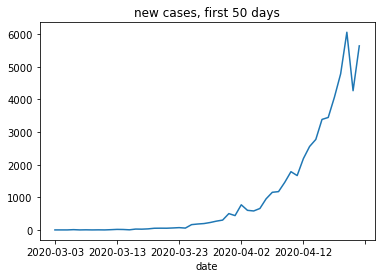

In [6]:
df_train.plot(x='date', y='new_cases', kind='line', title='new cases, first 50 days', legend=False)
plt.show()

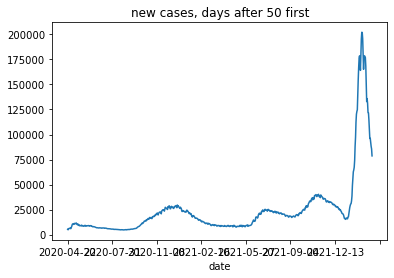

In [7]:
df_test.plot(x='date', y='new_cases', kind='line', title='new cases, days after 50 first', legend=False)
plt.show()

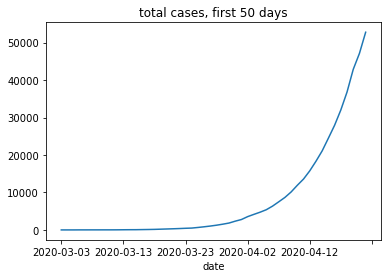

In [8]:
df_train.plot(x='date', y='total_cases', kind='line', title='total cases, first 50 days', legend=False)
plt.show()

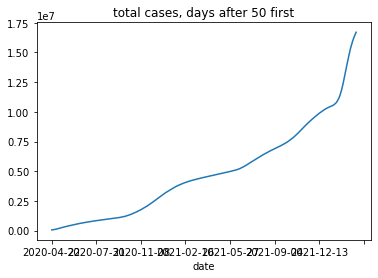

In [9]:
df_test.plot(x='date', y='total_cases', kind='line', title='total cases, days after 50 first', legend=False)
plt.show()

Кажется, проводить регрессию нужно для общего числа случаев (не новых), но на всякий случай сделаем и для новых один раз. Посмотрим на графики в лог-шкале и обычной. Линии - это предсказания модели, точки - реальные данные.

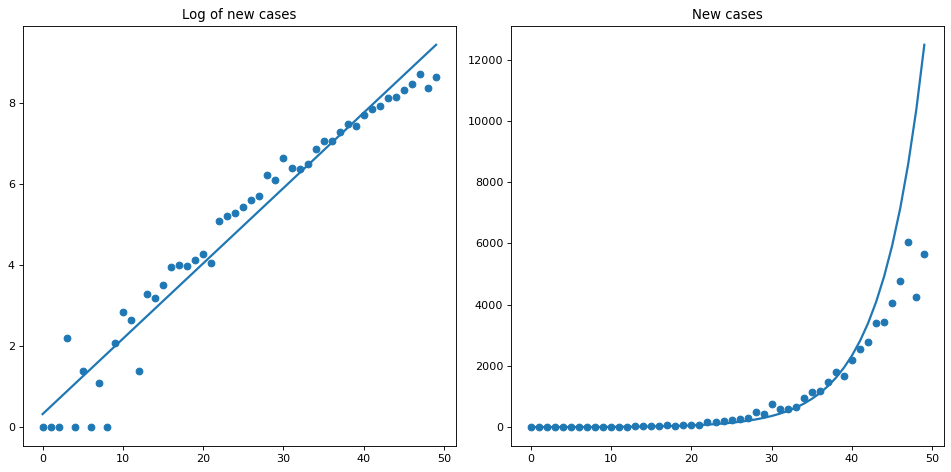

In [10]:
x = df_train.index.values.reshape(-1, 1)

y = df_train['new_cases']
ln_y = np.log(df_train['new_cases'])

cur_model = LinearRegression(fit_intercept=True).fit(x, ln_y)

plt.figure(figsize=(12, 6), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(x, cur_model.predict( x ), linewidth=2)#, label="$d=%d$" % d)
plt.scatter(x, ln_y)
plt.title('Log of new cases')

plt.subplot(1, 2, 2)
plt.plot(x, np.exp(cur_model.predict(x)), linewidth=2)
plt.scatter(x, y)
plt.title('New cases')

plt.tight_layout()
plt.show()

Уже на первых пятидесяти днях видно, что модель предсказывает более суровую динамику, чем реальность. Теперь прогоним регрессию для общего числа случаев.

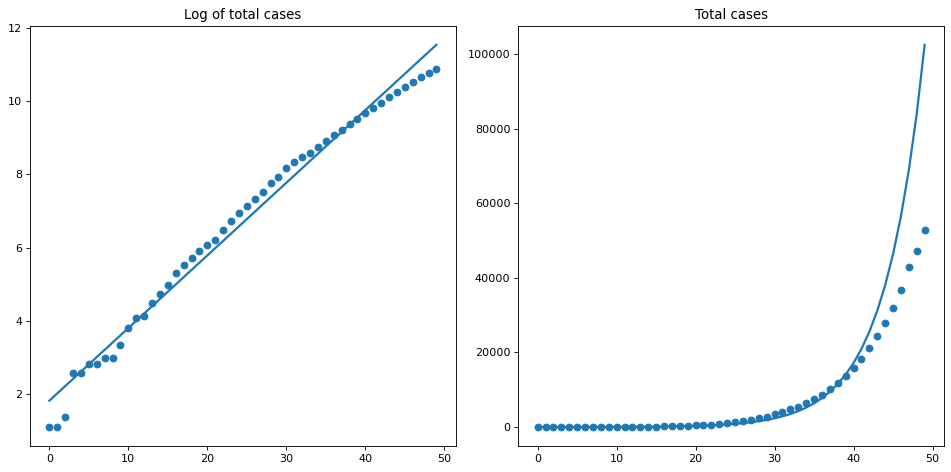

In [11]:
x = df_train.index.values.reshape(-1, 1)

y = df_train['total_cases']

ln_y = np.log(df_train['total_cases'])
t = ln_y
N = t.size

cur_model = LinearRegression(fit_intercept=True).fit(x, ln_y)

plt.figure(figsize=(12, 6), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(x, cur_model.predict(x), linewidth=2)
plt.scatter(x, ln_y)
plt.title('Log of total cases')

plt.subplot(1, 2, 2)
plt.plot(x, np.exp(cur_model.predict(x)), linewidth=2)
plt.scatter(x, y)
plt.title('Total cases')

plt.tight_layout()
plt.show()

Дальше пока (до конца второго пункта домашнего задания) будем изучать динамику общего числа случаев. 
Будем считать, что веса для линейной регрессии априорно имеют нормальное распределение: $w \sim N(\mu_0, \Sigma_0$) --- это довольно широкий класс распределений и он является сопряженным к семейству нормального распределения правдоподобий (а в линейной регрессии правдоподобие как раз такое).

Значение дисперсии шума данных --- это, как мы знаем, $\sigma^2_{ML} = \frac{1}{N} \Sigma_{n=1}^N (t_n - w^T_{ML} x_n)^2$. Посчитаем эту выборочную дисперсию:

In [12]:
sigma2ML = np.sum((t - cur_model.predict(x)) ** 2) / N
sigma2ML

0.12183046154391232

Воспользуемся формулами для параметров гауссиана в апостериорном распределении: $$\Sigma_N = (\Sigma_0^{-1} + 
                                                                                              \frac{1}{\sigma^2} X^T X
                                                                                             )^{-1}, $$
$$\mu_N = \Sigma_N (\Sigma_0^{-1} \mu_0  + \frac{1}{\sigma^2} X^T t).
$$

Будем считать, что $\mu_0 = 0, \Sigma_0 = \alpha I$.

In [13]:
def calculate_mu_and_sigma(mu0, Sigma0, sigma2, X, t):
    
    SigmaN = np.linalg.inv(np.linalg.inv(Sigma0) + 1 / sigma2ML * X.T @ X)
    muN = SigmaN @ (np.linalg.inv(Sigma0) @ mu0 + 1 / sigma2ML * X.T @ t)
    
    return muN, SigmaN

In [14]:
t = np.log(df_train['total_cases'])
N = t.size

x = df_train.index.values.reshape(-1, 1)
const = np.ones(N).reshape(-1, 1)
X = np.hstack((x, const))

In [15]:
mu0 = np.zeros(2)
alpha = 1
Sigma0 = alpha * np.identity(2)

muN, SigmaN = calculate_mu_and_sigma(mu0, Sigma0, sigma2ML, X, t)

Посэмплируем экспоненты и построим их (черными тонкими линиями) на общем графике вместе с реальными данными (красная линия).

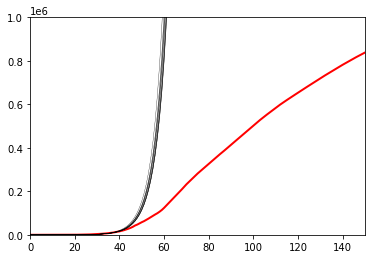

In [16]:
x_total = df_all.index.values.reshape(-1, 1)
const_total = np.ones(x_total.size).reshape(-1, 1)
X_total = np.hstack((x_total, const_total))
y_total = np.array(df_all['total_cases'])

plt.plot(x_total, y_total, color='r', linewidth=2)

for i in range(0, 10):
    w_sampled = np.random.multivariate_normal(muN, SigmaN)
    t_pred_total = w_sampled @ X_total.T
    plt.ylim(bottom=0, top=10**6)
    plt.xlim(left=0, right=150)
    plt.plot(x_total, np.exp(t_pred_total), color='k', linewidth=0.3)

Видно, что через примерно полтора месяца предсказания драматически расходятся с реальностью - экспоненты взмывают вверх, тогда как реальное количество случаев растет гораздо медленнее.
Их даже неудобно размещать на общем графике. Построим теперь только график предсказаний (чтобы посмотреть, что предсказывается к сентябрю). 1 мая - это примерно через 60 дней, 1 июня - через 90 дней, 1 сентября - через 180 дней. У каждого графика вручную выберем свои границы осей, чтобы было лучше видно.

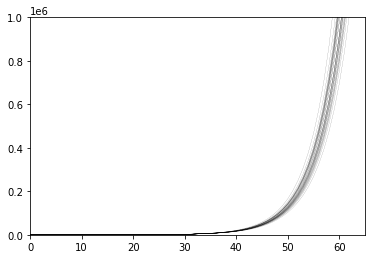

In [17]:
for i in range(0, 30):
    w_sampled = np.random.multivariate_normal(muN, SigmaN)
    t_pred_total = w_sampled @ X_total.T
    plt.ylim(bottom=0, top=10**6)
    plt.xlim(left=0, right=65)
    plt.plot(x_total, np.exp(t_pred_total), color='k', linewidth=0.1)
    
plt.show()

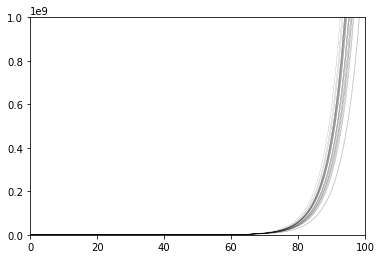

In [18]:
for i in range(0, 30):
    w_sampled = np.random.multivariate_normal(muN, SigmaN)
    t_pred_total = w_sampled @ X_total.T
    plt.ylim(bottom=0, top=10**9)
    plt.xlim(left=0, right=100)
    plt.plot(x_total, np.exp(t_pred_total), color='k', linewidth=0.1)
    
plt.show()

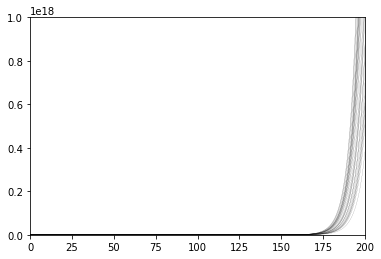

In [19]:
for i in range(0, 30):
    w_sampled = np.random.multivariate_normal(muN, SigmaN)
    t_pred_total = w_sampled @ X_total.T
    plt.ylim(bottom=0, top=10**18)
    plt.xlim(left=0, right=200)
    plt.plot(x_total, np.exp(t_pred_total), color='k', linewidth=0.1)
    
plt.show()

Из этих графиков примерно видно, что предсказания такого порядка: к 1 мая - около 1 млн, к 1 июня - около 1 млрд, к 1 сентября - порядка $10^{17} - 10^{18}$ - экспонента, что поделаешь.

Теперь перейдем к третьей части задания: будем считать, что число всех случаев растет по сигмоиде. То есть 
$$ total\_cases = \int_{\infty}^{x} e^{at^2 + bt + c} \, dt$$

Заметим, что производная общего числа случаев - это прирост числа случаев, то есть количество новых случаев . А справа будет экспонента квадратичной функции. Поэтому возьмем в качестве целевой переменной логарифм от числа новых случаев, и будем проводить регрессию на три признака - константу, номер дня и квадрат номера дня. По-прежнему считаем шум распределенным нормально с $\mu_0 = 0, \Sigma_0 = \alpha I$, и сопряженное ему распределение параметров тоже будет нормальным.

In [20]:
x = df_train.index.values.reshape(-1, 1)
x2 = x ** 2
const = np.ones(N).reshape(-1, 1)
Xsq = np.hstack((x2, x, const))

In [21]:
ln_new_cases = np.log(df_train['new_cases'])

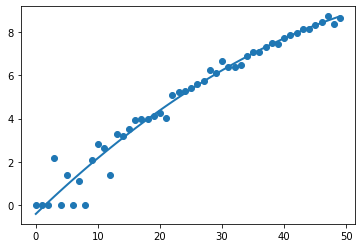

In [22]:
sigmoid_model = LinearRegression(fit_intercept=False).fit(Xsq, ln_new_cases)

plt.plot(Xsq[:, 1], sigmoid_model.predict(Xsq), linewidth=2)
plt.scatter(Xsq[:, 1], ln_new_cases)
plt.show()

In [23]:
sigma2MLsigmoid = np.sum((ln_new_cases - sigmoid_model.predict(Xsq)) ** 2) / N
sigma2MLsigmoid

0.23928684127005562

In [24]:
mu0 = np.zeros(3)
alpha = 1
Sigma0 = alpha * np.identity(3)

muN, SigmaN = calculate_mu_and_sigma(mu0, Sigma0, sigma2ML, Xsq, ln_new_cases)

(734, 3)


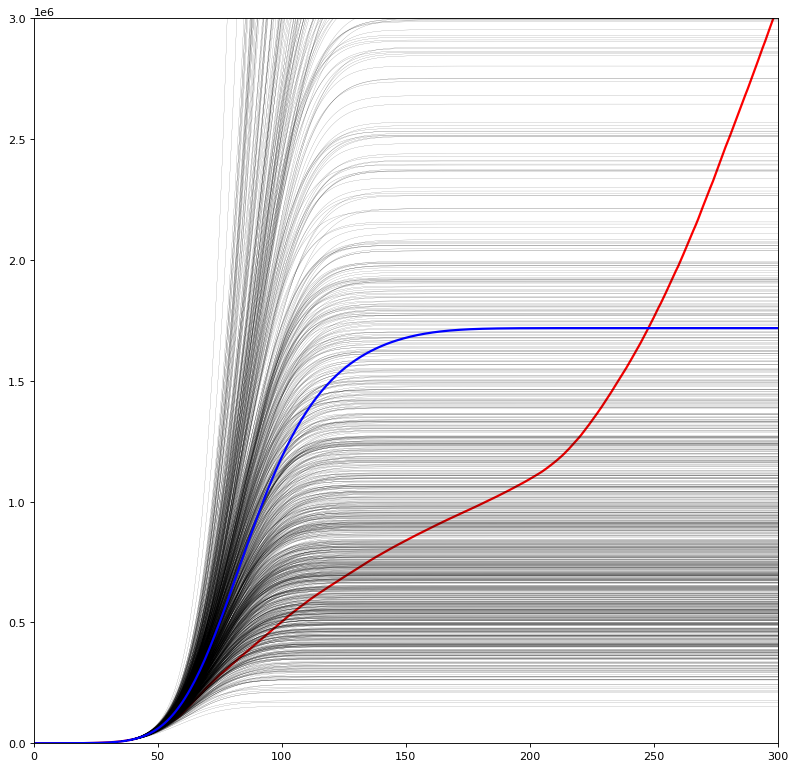

In [25]:
x_total = df_all.index.values.reshape(-1, 1)
x_sq_total = x_total ** 2
const_total = np.ones(x_total.size).reshape(-1, 1)
X_total = np.hstack((x_sq_total, x_total, const_total))
print(X_total.shape)
y_total = np.array(df_all['total_cases'])

plt.figure(figsize=(12, 12), dpi=80)
plt.plot(x_total, y_total, color='r', linewidth=2)

res = []

for i in range(0, 1000):
    w_sampled = np.random.multivariate_normal(muN, SigmaN)
    t_sigmoid_pred_ln_new_cases = w_sampled @ X_total.T
    t_sigmoid_pred_new_cases = np.exp(t_sigmoid_pred_ln_new_cases)
    t_sigmoid_pred_total_cases = np.cumsum(t_sigmoid_pred_new_cases)
    res.append(t_sigmoid_pred_total_cases)
    plt.ylim(bottom=0, top=3 * 10**6)
    plt.xlim(left=0, right=300)
    plt.plot(x_total, t_sigmoid_pred_total_cases, color='k', linewidth=0.1)
    
plt.plot(x_total, np.mean(res, axis=0), color='blue', linewidth=2)

По графику видно, что к 200-ому дню сигмоиды примерно стабилизируются, поэтому чтобы найти асимптоту в хорошем и плохом сценариях, возьмем сумму новых случаев к 200-ому дню.

In [26]:
res = np.stack(res, axis=0)
np.around(np.percentile(res[:,200], (10, 90)), 0)

array([ 417620., 2997636.])

Получается, что в оптимистичном сценарии ожидается примерно полмиллиона случаев, а в пессимистичном - три миллиона. 

Теперь попробуем провести анализ для разных стран. У меня получилось 28 стран (пока не надоело).

Для каждой страны найдем (вручную) день, когда больше двух заболевших (в Индии начала с больше трех, потому что там почти месяц было ровно три заболевших).

In [27]:
date_data =np.array([['Sweden', 'United States', 'Germany', 'United Kingdom', 'Belarus', 'France', 'China', 'Australia', 
                     'Canada', 'Finland', 'Italy', 'Singapore', 'Russia', 'Mongolia', 'India', 'Turkey', 
                      'Lithuania', 'Portugal', 'South Africa', 'Egypt', 'New Zealand', 'Namibia', 'Iceland', 'Kazakhstan', 
                     'Monaco', 'Hong Kong', 'Bangladesh', 'Lebanon'],
                     
        ['2020-02-27', '2020-01-26', '2020-01-28', '2020-02-03', '2020-03-04', '2020-01-25', '2020-01-22', '2020-01-26', 
         '2020-01-31', '2020-02-23', '2020-02-07', '2020-01-24', '2020-03-02', '2020-03-17', '2020-03-02', '2020-03-13', 
        '2020-03-11', '2020-03-04', '2020-03-08', '2020-03-05', '2020-03-04', '2020-03-19', '2020-03-01', '2020-03-13', 
        '2020-03-16', '2020-01-25', '2020-03-08', '2020-02-29']])

date_data.size / 2

28.0

In [28]:
size = int(date_data.size/2)
res = []
for i in range(size):
    df_all, df_train, df_test = preprocessing(df, date_data[0,i], date_data[1,i])
    x = df_train.index.values.reshape(-1, 1)

    y = df_train['total_cases']

    ln_y = np.log(df_train['total_cases'])
    t = ln_y
    N = t.size

    cur_model = LinearRegression(fit_intercept=True).fit(x, ln_y)
    
    
    res.append([date_data[0,i], cur_model.coef_[0], cur_model.intercept_])

In [29]:
res = np.array(res)
coef = res[:,1].astype(float)
const = res[:,2].astype(float)
labels = res[:,0]


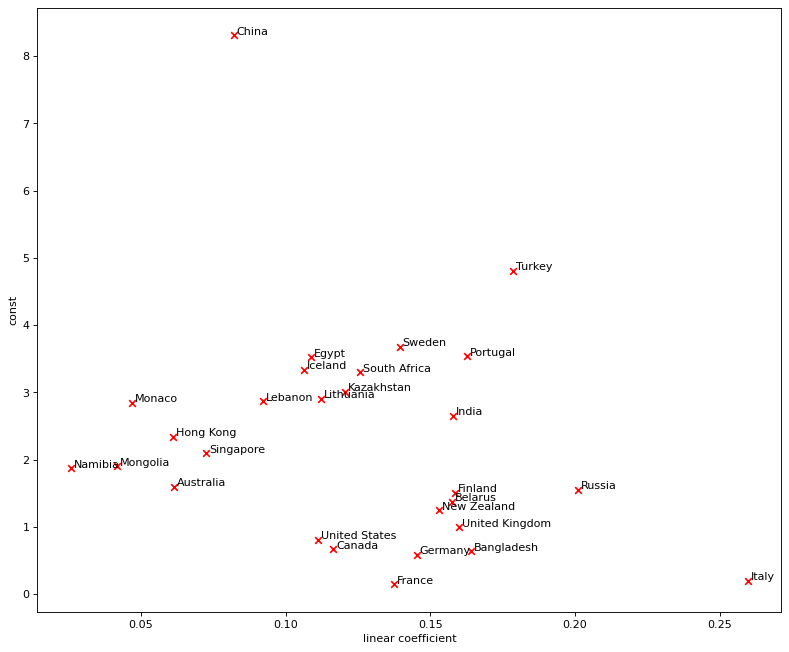

In [30]:
plt.figure(figsize=(12, 10), dpi=80)
for i in range(size):
    x = coef[i]
    y = const[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.001, y+0.01, res[i,0], fontsize=10)
    plt.xlabel("linear coefficient")
    plt.ylabel("const")

plt.show()

В этой статистике выделяется Китай - очевидно потому, что он попадает в  не на начальной стадии эпидемии, это видно невооруженным глазом сразу в файле. Поэтому на Китай не будем обращать внимания. 

Есть группка стран с низким линейным коэффициентом (не константой) - то есть скоростью распространения по дням. Это Намибия, Монголия, Австралия, Гонконг, Сингапур, Монако. Вообще у меня была гипотеза, что в странах с низкой плотностью населения скорость распространения должна быть ниже (и потом я дополнила свой изначальный список стран странами с очень высокой и с очень низкой плотностью населения, чтобы проверить эту гипотезу). Однако, медленно вирус распространялся также в густонаселенных Гонкогне и Сингапуре - видимо, благодаря дисциплинированности населения, ношению масок, строгому соблюдению карантина (в т.ч. из-за опыта SARS). 

Вообще зрительно различаются две группы: у зеленой при той же константе линейный коэффициент меньше, чем у голубой. То есть при сопоставимом числе заболевших, выше скорость роста. Этот кластер включает в себя уже упомянутые страны с низкой скоростью распространения заболевания, но еще там есть Исландия, Казахстан, Швеция (низкая плотность населения), и не очень понятные мне Ливан, Литва, Индия (возможно, в Индии плохой учет заболевших?) и прочие.

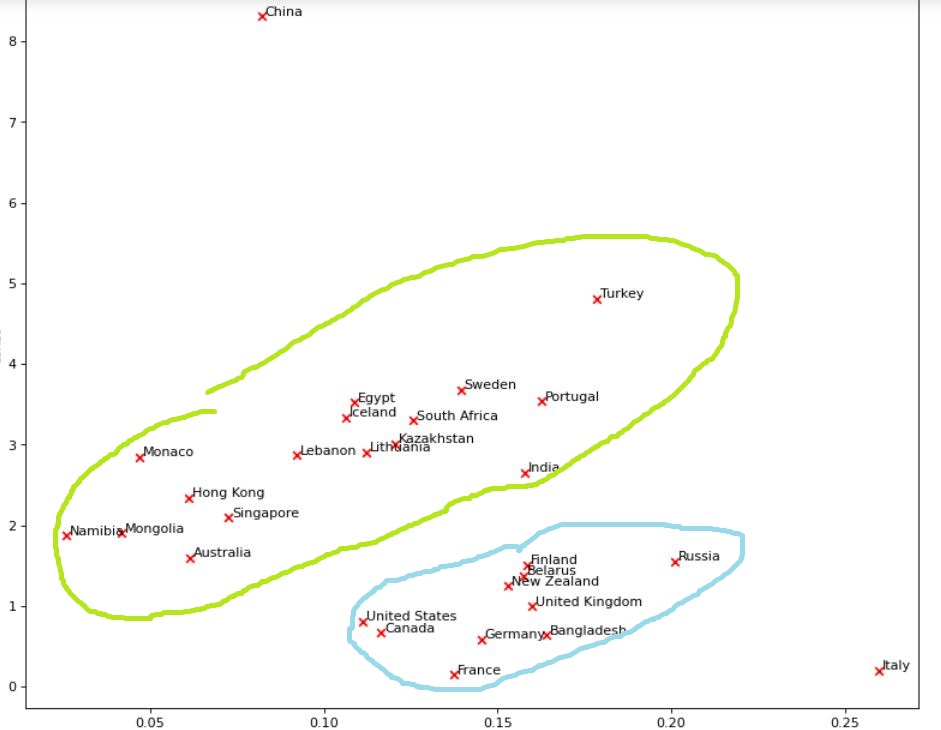